In [98]:
import pandas as pd

In [99]:
df = pd.read_csv('used_cars.csv')

First, I wanted to get a general overview of the data.

In [100]:
df.head(5)

,Unnamed: 0,car_name,registration_year,insurance_validity,fuel_type,seats,kms_driven,ownsership,transmission,manufacturing_year,mileage(kmpl),engine(cc),max_power(bhp),torque(Nm),price(in lakhs)
0,0,2017 Mercedes-Benz S-Class S400,Jul-17,Comprehensive,Petrol,5,56000,First Owner,Automatic,2017,7.81,2996.0,2996.0,333.0,63.75
1,1,2020 Nissan Magnite Turbo CVT XV Premium Opt BSVI,Jan-21,Comprehensive,Petrol,5,30615,First Owner,Automatic,2020,17.40,999.0,999.0,9863.0,8.99
2,2,2018 BMW X1 sDrive 20d xLine,Sep-18,Comprehensive,Diesel,5,24000,First Owner,Automatic,2018,20.68,1995.0,1995.0,188.0,23.75
3,3,2019 Kia Seltos GTX Plus,Dec-19,Comprehensive,Petrol,5,18378,First Owner,Manual,2019,16.50,1353.0,1353.0,13808.0,13.56
4,4,2019 Skoda Superb LK 1.8 TSI AT,Aug-19,Comprehensive,Petrol,5,44900,First Owner,Automatic,2019,14.67,1798.0,1798.0,17746.0,24.00


Looking at the dataset, I noticed several issues that require addressing. First, I want to change the mileage to L/100 km, since this is far more familiar to me as a European. The second issue is the max_power(bhp) column, where the values are obviously incorrect, since the 2017 Mercedes-Benz S-Class S400 is listed to have almost 3,000 horsepower, while in reality, that figure is closer to 300. It appears that the figures in this column are about 10x higher than they should be, which will need fixing. Unfortunately, there is no available information about these columns, which is why the max_power(bhp) column will be adjusted (all values divided by 10) and the torque(Nm) column will be disregarded entirely. Finally, the last column, price(inlakhs) will be converted to euros.

In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1553 entries, 0 to 1552
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          1553 non-null   int64  
 1   car_name            1553 non-null   object 
 2   registration_year   1553 non-null   object 
 3   insurance_validity  1553 non-null   object 
 4   fuel_type           1553 non-null   object 
 5   seats               1553 non-null   int64  
 6   kms_driven          1553 non-null   int64  
 7   ownsership          1553 non-null   object 
 8   transmission        1553 non-null   object 
 9   manufacturing_year  1553 non-null   object 
 10  mileage(kmpl)       1550 non-null   float64
 11  engine(cc)          1550 non-null   float64
 12  max_power(bhp)      1550 non-null   float64
 13  torque(Nm)          1549 non-null   float64
 14  price(in lakhs)     1553 non-null   float64
dtypes: float64(5), int64(3), object(7)
memory usage: 182.1+

In [102]:
df.describe()

,Unnamed: 0,seats,kms_driven,mileage(kmpl),engine(cc),max_power(bhp),torque(Nm),price(in lakhs)
count,1553.000000,1553.000000,1553.000000,1550.000000,1.550000e+03,1.550000e+03,1.549000e+03,1553.000000
mean,776.000000,91.480361,52841.931101,236.927277,1.471857e+10,1.471857e+10,1.423989e+04,166.141494
std,448.456798,2403.424060,40067.800347,585.964295,2.185629e+11,2.185629e+11,9.666241e+04,3478.855090
min,0.000000,4.000000,620.000000,7.810000,5.000000e+00,5.000000e+00,5.000000e+00,1.000000
25%,388.000000,5.000000,30000.000000,16.342500,1.197000e+03,1.197000e+03,4.000000e+02,4.660000
50%,776.000000,5.000000,49134.000000,18.900000,1.462000e+03,1.462000e+03,1.173000e+03,7.140000
75%,1164.000000,5.000000,70000.000000,22.000000,1.995000e+03,1.995000e+03,8.850000e+03,17.000000
max,1552.000000,67000.000000,810000.000000,3996.000000,3.258640e+12,3.258640e+12,1.464800e+06,95000.000000


There are some obvious outliers in this dataset, namely the max for seats and mileage. Also, the types in engine(cc) and max_power(bhp) will be changed.

In [103]:
df.shape

(1553, 15)

I first wanted to convert the price from lakh to euros, for which I needed the current exchange rate. I used an API for that.

In [104]:
import requests

API_KEY = '266dabd36192ee83779d85fb'
base_currency = 'INR'
target_currency = 'EUR'

url = f'https://v6.exchangerate-api.com/v6/{API_KEY}/pair/{base_currency}/{target_currency}'

response = requests.get(url)

if response.status_code == 200:
    data = response.json()
    exchange_rate = data['conversion_rate']  #I saved the exchange rate as a variable to use later.
else:
    raise Exception(f"API request failed with status code {response.status_code}")


In [105]:
#I added a new column called price(eur), which I populated with the price in euros. 
#First, I had to convert lakh to INR by multiplying the entries by 100,000. 
lakh_to_inr = 100000
#I then 
df['price(eur)'] = df['price(in lakhs)'] * lakh_to_inr * exchange_rate

In [106]:
#Since I had no use for the price in lakhs, I decided to permanently delete that column.
df.drop(columns=['price(in lakhs)'], inplace=True)

I then decided to change the mileage from kmpl to L/100 km and to do this without adding or deleting columns.

In [107]:
#First, I renamed the column from mileage(kmpl) to L/100
df.rename(columns={'mileage(kmpl)': 'L/100'}, inplace=True)

In [108]:
#Then, I used the formula 100/kmpl to change the values so they are in the correct unit.
df['L/100'] = round(100 / df['L/100'], 2)
df.head()

,Unnamed: 0,car_name,registration_year,insurance_validity,fuel_type,seats,kms_driven,ownsership,transmission,manufacturing_year,L/100,engine(cc),max_power(bhp),torque(Nm),price(eur)
0,0,2017 Mercedes-Benz S-Class S400,Jul-17,Comprehensive,Petrol,5,56000,First Owner,Automatic,2017,12.80,2996.0,2996.0,333.0,66618.75
1,1,2020 Nissan Magnite Turbo CVT XV Premium Opt BSVI,Jan-21,Comprehensive,Petrol,5,30615,First Owner,Automatic,2020,5.75,999.0,999.0,9863.0,9394.55
2,2,2018 BMW X1 sDrive 20d xLine,Sep-18,Comprehensive,Diesel,5,24000,First Owner,Automatic,2018,4.84,1995.0,1995.0,188.0,24818.75
3,3,2019 Kia Seltos GTX Plus,Dec-19,Comprehensive,Petrol,5,18378,First Owner,Manual,2019,6.06,1353.0,1353.0,13808.0,14170.20
4,4,2019 Skoda Superb LK 1.8 TSI AT,Aug-19,Comprehensive,Petrol,5,44900,First Owner,Automatic,2019,6.82,1798.0,1798.0,17746.0,25080.00


Then, I corrected the max_power(bhp) column by dividing all values with 10.

In [109]:
df['max_power(bhp)'] = df['max_power(bhp)'] / 10

After which, I deleted the torque column.

In [110]:
df.drop(columns=['torque(Nm)'], inplace=True)

Once again, I wanted to inspect my dataset.

In [111]:
df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1553 entries, 0 to 1552
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          1553 non-null   int64  
 1   car_name            1553 non-null   object 
 2   registration_year   1553 non-null   object 
 3   insurance_validity  1553 non-null   object 
 4   fuel_type           1553 non-null   object 
 5   seats               1553 non-null   int64  
 6   kms_driven          1553 non-null   int64  
 7   ownsership          1553 non-null   object 
 8   transmission        1553 non-null   object 
 9   manufacturing_year  1553 non-null   object 
 10  L/100               1550 non-null   float64
 11  engine(cc)          1550 non-null   float64
 12  max_power(bhp)      1550 non-null   float64
 13  price(eur)          1553 non-null   float64
dtypes: float64(4), int64(3), object(7)
memory usage: 170.0+ KB


I decided to inspect the 3 rows with null values, to see, if I can find the relevant information online, so that I wouldn't have to delete them.

In [112]:
df[df.isnull().any(axis=1)]

,Unnamed: 0,car_name,registration_year,insurance_validity,fuel_type,seats,kms_driven,ownsership,transmission,manufacturing_year,L/100,engine(cc),max_power(bhp),price(eur)
513,513,2011 Toyota Etios G,Dec-11,Comprehensive,Petrol,5,51710,First Owner,Manual,2011,NaN,NaN,NaN,2591.60
533,533,2011 Toyota Etios G,Dec-11,Comprehensive,Petrol,5,51710,First Owner,Manual,2011,NaN,NaN,NaN,2591.60
589,589,2011 Toyota Etios G,Jul-11,Comprehensive,Petrol,5,54214,First Owner,Manual,2011,NaN,NaN,NaN,2664.75


I decided to look online for the missing information, since it was for only one model of car. I also found that indexes 513 and 533 are duplicates, so I dropped one of them. However, I couldn't use df.drop_duplicates(), because the column 'Unnamed: 0' has different values, so I had to delete that one first.

In [113]:
df.drop(columns=['Unnamed: 0'], inplace=True)
df = df.drop_duplicates() #I wanted to keep the first duplicate.

In [114]:
df[df.isnull().any(axis=1)]

,car_name,registration_year,insurance_validity,fuel_type,seats,kms_driven,ownsership,transmission,manufacturing_year,L/100,engine(cc),max_power(bhp),price(eur)
513,2011 Toyota Etios G,Dec-11,Comprehensive,Petrol,5,51710,First Owner,Manual,2011,NaN,NaN,NaN,2591.60
589,2011 Toyota Etios G,Jul-11,Comprehensive,Petrol,5,54214,First Owner,Manual,2011,NaN,NaN,NaN,2664.75


After searching online, I found that the petrol version of the car in question comes with a 1.2 and a 1.5 L engine, and given that there is no way to figure out which one is supposed to be in this dataset, I decided to drop all the rows with the null values.

In [116]:
df.dropna()

,car_name,registration_year,insurance_validity,fuel_type,seats,kms_driven,ownsership,transmission,manufacturing_year,L/100,engine(cc),max_power(bhp),price(eur)
0,2017 Mercedes-Benz S-Class S400,Jul-17,Comprehensive,Petrol,5,56000,First Owner,Automatic,2017,12.80,2996.0,299.6,66618.75
1,2020 Nissan Magnite Turbo CVT XV Premium Opt BSVI,Jan-21,Comprehensive,Petrol,5,30615,First Owner,Automatic,2020,5.75,999.0,99.9,9394.55
2,2018 BMW X1 sDrive 20d xLine,Sep-18,Comprehensive,Diesel,5,24000,First Owner,Automatic,2018,4.84,1995.0,199.5,24818.75
3,2019 Kia Seltos GTX Plus,Dec-19,Comprehensive,Petrol,5,18378,First Owner,Manual,2019,6.06,1353.0,135.3,14170.20
4,2019 Skoda Superb LK 1.8 TSI AT,Aug-19,Comprehensive,Petrol,5,44900,First Owner,Automatic,2019,6.82,1798.0,179.8,25080.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1548,2020 Hyundai Creta SX Opt Diesel AT BSVI,Aug-20,Comprehensive,Diesel,5,35000,First Owner,Automatic,2020,0.07,11345.0,1134.5,18193.45
1549,2022 Renault KWID 1.0 RXL Opt BSVI,2022,Third Party insurance,Petrol,5,10000,999 cc,2022,Power Steering,0.10,6706.0,670.6,4159.10
1550,2017 Honda WR-V i-VTEC S,Jun-17,Comprehensive,Petrol,5,49000,First Owner,Manual,2017,5.71,1199.0,119.9,6113.25
1551,2018 Volkswagen Polo 1.0 MPI Comfortline,May-18,Comprehensive,Petrol,5,40000,Second Owner,Manual,2018,5.32,999.0,99.9,4963.75


I noticed one of the column names is misspelled, so I changed it.)

In [120]:
df.rename(columns={'ownsership': 'ownership'}, inplace=True)

In [121]:
df['transmission'].unique()

array(['Automatic', 'Manual', '2017', '2014', '2023', '2020', '2021',
       '2011', '2022', 'Power Windows Front', '2018', '2015', '2016'],
      dtype=object)

In [122]:
df['ownership'].unique()

array(['First Owner', 'Second Owner', 'Third Owner', '2993 cc', '1461 cc',
       '998 cc', '1995 cc', '1451 cc', '1998 cc', '1498 cc', '1497 cc',
       '1996 cc', '1950 cc', '2013', 'Fifth Owner', '1199 cc', '1248 cc',
       '999 cc', '1197 cc', '1984 cc', '2999 cc', '1968 cc'], dtype=object)

In [123]:
df['fuel_type'].unique()

array(['Petrol', 'Diesel', 'CNG', '5 Seats'], dtype=object)

In [124]:
df['manufacturing_year'].unique()

array(['2017', '2020', '2018', '2019', '2015', '2021', '2014', '2022',
       '2010', '2011', '2023', '2016', '2009', '2013', 'Power Steering',
       '2012', 'Power Windows Front', 'Air Conditioner', '2007'],
      dtype=object)

In [125]:
df['insurance_validity'].unique()

array(['Comprehensive', 'Third Party insurance', 'Zero Dep',
       'Third Party', 'Petrol', 'Not Available'], dtype=object)

In [126]:
df['seats'].unique()

array([    5,     6,     7,     4,     8, 67000])

I noticed many incorrect values in the columns and withouth the author of the data, I had no conceivable way of correcting them. Nevertheless, I still decided to attempt to do some basic data analysis.

In [127]:
#I first wanted to see, how many cars run on which type of fuel.
fuel_percentages = df['fuel_type'].value_counts(normalize=True) * 100
print(fuel_percentages)

fuel_type
Petrol     66.284201
Diesel     32.127096
CNG         1.500441
5 Seats     0.088261
Name: proportion, dtype: float64


In [128]:
#Given that the share of cars with '5 seats' as their fuel source, I wanted to find them.
five_seat = df[df['fuel_type'] == '5 Seats']
five_seat

,car_name,registration_year,insurance_validity,fuel_type,seats,kms_driven,ownership,transmission,manufacturing_year,L/100,engine(cc),max_power(bhp),price(eur)
798,2013 Mercedes-Benz E-Class E 200 CGI Avantgarde,Third Party insurance,Petrol,5 Seats,67000,1796,2013,Power Windows Front,Air Conditioner,0.35,17.0,1.7,17242.5


Since I found that the car in question uses petrol, I decided to correct that mistake. I also discovered that this car is listed as having 67000 seats, so I decided to fix that too.

In [129]:
df.loc[798, 'fuel_type'] = 'Petrol'
df.loc[798, 'seats'] = 5

In [130]:
df['fuel_type'].unique()

array(['Petrol', 'Diesel', 'CNG'], dtype=object)

In [131]:
df['seats'].unique()

array([5, 6, 7, 4, 8])

In [132]:
fuel_percentages = df['fuel_type'].value_counts(normalize=True) * 100
print(fuel_percentages)

fuel_type
Petrol    66.372462
Diesel    32.127096
CNG        1.500441
Name: proportion, dtype: float64


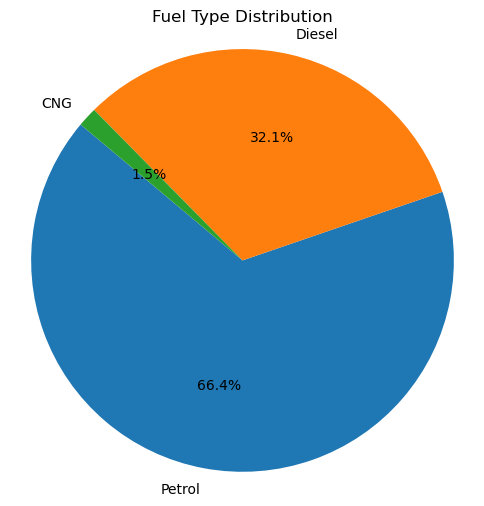

In [133]:
#Now that I have the correct data, I wanted to show it in a pie chart using matplotlib.
import matplotlib.pyplot as plt

# Plot pie chart
plt.figure(figsize=(6, 6))
plt.pie(fuel_percentages, labels=fuel_percentages.index, autopct='%1.1f%%', startangle=140)
plt.title('Fuel Type Distribution')
plt.axis('equal')  # Ensures pie is a circle
plt.show()

In [134]:
#Next, I attempted to visualise the number of seats available in the cars.
no_of_seats = df['seats'].value_counts(normalize=True) * 100
no_of_seats = no_of_seats.round(2)
print(no_of_seats)

seats
5    88.00
7     9.53
4     1.32
6     0.97
8     0.18
Name: proportion, dtype: float64


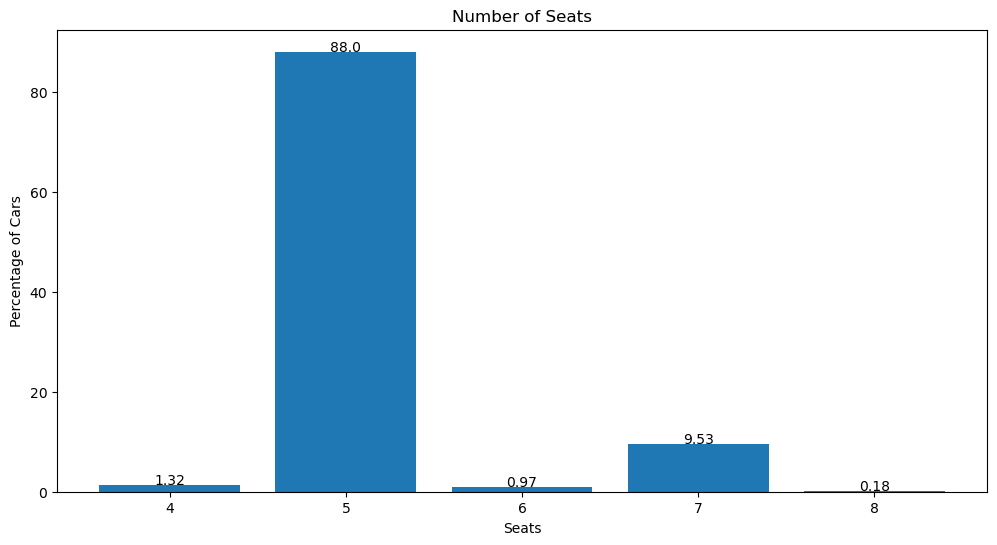

In [135]:
#I decided to show this information on a bar chart
# Plot bar chart
plt.figure(figsize=(12, 6))
plt.bar(no_of_seats.index, no_of_seats.values)
plt.title('Number of Seats')
plt.xlabel('Seats')
plt.ylabel('Percentage of Cars')

for x, val in zip(no_of_seats.index, no_of_seats.values):
    plt.text(x, val + 0.1, str(val), ha='center')

plt.show()

In [136]:
df.describe()

,seats,kms_driven,L/100,engine(cc),max_power(bhp),price(eur)
count,1133.000000,1133.000000,1131.000000,1.131000e+03,1.131000e+03,1.133000e+03
mean,5.192410,53115.190644,4.952803,1.152627e+10,1.152627e+09,1.665820e+05
std,0.619226,43091.691905,2.373018,1.935342e+11,1.935342e+10,3.661422e+06
min,4.000000,620.000000,0.030000,5.000000e+00,5.000000e-01,1.045000e+03
25%,5.000000,30000.000000,4.470000,1.197000e+03,1.197000e+02,4.702500e+03
50%,5.000000,49000.000000,5.290000,1.461000e+03,1.461000e+02,7.053750e+03
75%,5.000000,70000.000000,6.040000,1.991000e+03,1.991000e+02,1.562275e+04
max,8.000000,810000.000000,12.800000,3.258640e+12,3.258640e+11,9.927500e+07


Since I wanted to show the price, power, and kms_drive distributions on a box plot, I first had to change the values. I first wanted to inspect them in more detail.

In [137]:
print(df[['engine(cc)', 'max_power(bhp)', 'price(eur)']].head(10))

   engine(cc)  max_power(bhp)  price(eur)
0      2996.0           299.6    66618.75
1       999.0            99.9     9394.55
2      1995.0           199.5    24818.75
3      1353.0           135.3    14170.20
4      1798.0           179.8    25080.00
5      1199.0           119.9     5695.25
6      1197.0           119.7     5350.40
7      1591.0           159.1     9718.50
8      2987.0           298.7    43890.00
9      1198.0           119.8     8380.90


In [139]:
# I removed commas and non-numeric characters, then convert to float
df['engine(cc)'] = df['engine(cc)'].astype(str).str.replace(r'[^\d.]', '', regex=True)
df['engine(cc)'] = pd.to_numeric(df['engine(cc)'], errors='coerce')  # 'coerce' will convert empty strings to NaN

df['max_power(bhp)'] = df['max_power(bhp)'].astype(str).str.replace(r'[^\d.]', '', regex=True)
df['max_power(bhp)'] = pd.to_numeric(df['max_power(bhp)'], errors='coerce')

df['price(eur)'] = df['price(eur)'].astype(str).str.replace(r'[^\d.]', '', regex=True)
df['price(eur)'] = pd.to_numeric(df['price(eur)'], errors='coerce')

In [140]:
df[['engine(cc)', 'max_power(bhp)', 'price(eur)']].describe()

,engine(cc),max_power(bhp),price(eur)
count,1.131000e+03,1.131000e+03,1.133000e+03
mean,1.152627e+10,1.152627e+09,1.665820e+05
std,1.935342e+11,1.935342e+10,3.661422e+06
min,5.000000e+00,5.000000e-01,1.045000e+03
25%,1.197000e+03,1.197000e+02,4.702500e+03
50%,1.461000e+03,1.461000e+02,7.053750e+03
75%,1.991000e+03,1.991000e+02,1.562275e+04
max,3.258640e+12,3.258640e+11,9.927500e+07


In [141]:
print(df[['engine(cc)', 'max_power(bhp)', 'price(eur)']].head(10))
print(df[['engine(cc)', 'max_power(bhp)', 'price(eur)']].tail(10))

   engine(cc)  max_power(bhp)  price(eur)
0      2996.0           299.6    66618.75
1       999.0            99.9     9394.55
2      1995.0           199.5    24818.75
3      1353.0           135.3    14170.20
4      1798.0           179.8    25080.00
5      1199.0           119.9     5695.25
6      1197.0           119.7     5350.40
7      1591.0           159.1     9718.50
8      2987.0           298.7    43890.00
9      1198.0           119.8     8380.90
      engine(cc)  max_power(bhp)  price(eur)
1543      1364.0           136.4     5486.25
1544      1591.0           159.1    11547.25
1545      8180.0           818.0     6165.50
1546      1199.0           119.9     6792.50
1547      1462.0           146.2    12017.50
1548     11345.0          1134.5    18193.45
1549      6706.0           670.6     4159.10
1550      1199.0           119.9     6113.25
1551       999.0            99.9     4963.75
1552      1197.0           119.7     6374.50


In [142]:
print(df.dtypes[['engine(cc)', 'max_power(bhp)', 'price(eur)']])

engine(cc)        float64
max_power(bhp)    float64
price(eur)        float64
dtype: object


In [88]:
df[df['engine(cc)'] > 5000]

,car_name,registration_year,insurance_validity,fuel_type,seats,kms_driven,ownership,transmission,manufacturing_year,L/100,engine(cc),max_power(bhp),price(eur)
75,2018 Maruti Wagon R CNG LXI,Feb-18,Comprehensive,CNG,5,45000,First Owner,Manual,2018,0.10,5833.0,583.3,4650.25
79,2018 Mahindra XUV500 W5,Jul-18,Third Party,Diesel,7,62000,Second Owner,Manual,2018,0.05,15287.0,1528.7,8882.50
116,2017 BMW 7 Series 730Ld M Sport,2017,Third Party insurance,Diesel,5,60000,2993 cc,2017,Power Steering,0.03,26149.0,2614.9,57475.00
142,2020 Mercedes-Benz GLE 300d BSVI,Oct-20,Zero Dep,Diesel,5,33000,First Owner,Automatic,2020,0.05,24138.0,2413.8,81510.00
145,2022 Mercedes-Benz GLE 300d BSVI,May-22,Zero Dep,Diesel,5,43703,First Owner,Automatic,2022,0.05,24138.0,2413.8,86630.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1504,2020 Hyundai Grand i10 Nios Sportz CNG,Oct-20,Comprehensive,CNG,5,27019,First Owner,Manual,2020,0.08,6805.0,680.5,7001.50
1513,2021 Audi Q2 Premium,Dec-21,Comprehensive,Petrol,5,9700,First Owner,Automatic,2021,0.05,18774.0,1877.4,37087.05
1545,2022 Maruti Ignis Sigma BSVI,2022,Third Party insurance,Petrol,5,2300,First Owner,Manual,2022,0.08,8180.0,818.0,6165.50
1548,2020 Hyundai Creta SX Opt Diesel AT BSVI,Aug-20,Comprehensive,Diesel,5,35000,First Owner,Automatic,2020,0.07,11345.0,1134.5,18193.45


In [143]:
#Because some values were unreasonably high and would render any attempt at showing them on a boxplot pointless, I decided to drop them from the dataset.
df = df[df['engine(cc)'] < 5000]
df = df[df['max_power(bhp)'] < 1000] 
df = df[df['price(eur)'] < 300000]

In [144]:
df.describe()

,seats,kms_driven,L/100,engine(cc),max_power(bhp),price(eur)
count,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000
mean,5.184160,54007.193702,5.310477,1506.353053,150.635305,14106.562691
std,0.608329,43922.434187,2.002446,643.297326,64.329733,17223.404121
min,4.000000,1000.000000,0.030000,5.000000,0.500000,1045.000000
25%,5.000000,30449.500000,4.670000,1197.000000,119.700000,4814.837500
50%,5.000000,50000.000000,5.325000,1373.000000,137.300000,7126.900000
75%,5.000000,70000.000000,6.090000,1950.000000,195.000000,14980.075000
max,8.000000,810000.000000,12.800000,4733.000000,473.300000,103455.000000


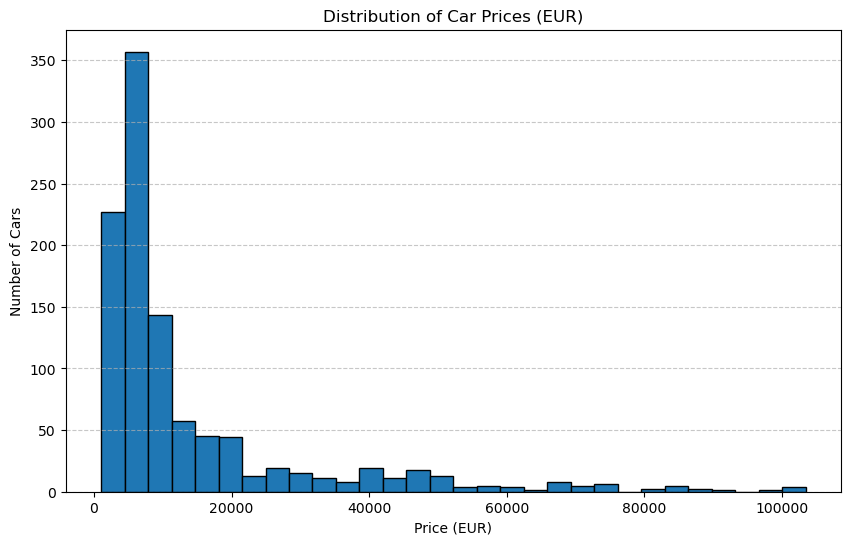

In [150]:
#I decided to now show the ditribution of price on a histogram

plt.figure(figsize=(10, 6))
plt.hist(df['price(eur)'].dropna(), bins=30, edgecolor='black')
plt.title('Distribution of Car Prices (EUR)')
plt.xlabel('Price (EUR)')
plt.ylabel('Number of Cars')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

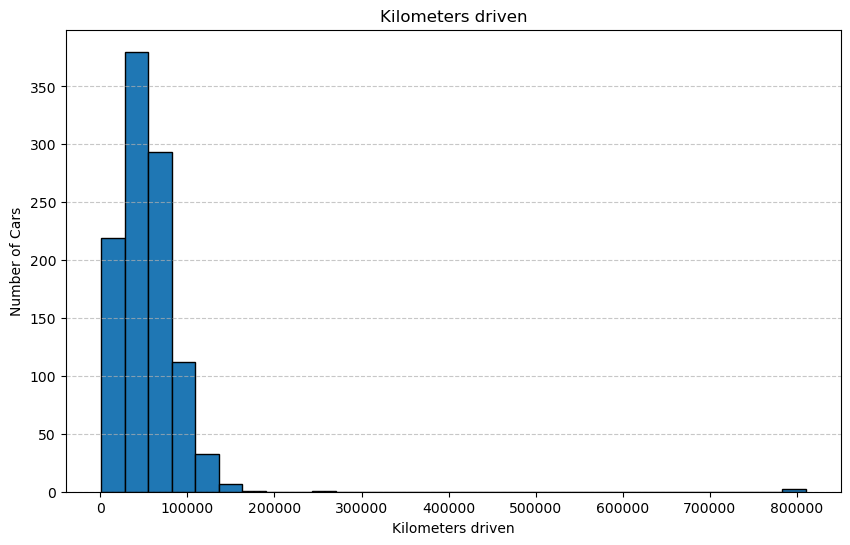

In [153]:
#I also wanted to show the kms_driven on a histogram
plt.figure(figsize=(10, 6))
plt.hist(df['kms_driven'].dropna(), bins=30, edgecolor='black')
plt.title('Kilometers driven')
plt.xlabel('Kilometers driven')
plt.ylabel('Number of Cars')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()